# Phase learning

## Prepare data

In [1]:
import csv
import numpy as np

In [2]:
def load_pca(file):
    pca4 = []
    with open(file, "r") as f:
        reader = csv.reader(f)
        for i in reader:
            pca4.append([complex(j.replace("i", "j")) for j in i])
    pca4 = np.array(pca4).T
    pca4_phase1 = pca4[:100]
    pca4_phase2 = pca4[100:]
    return pca4_phase1, pca4_phase2


pca16_phase1, pca16_phase2 = load_pca("DR16_phase.csv")
pca8_phase1, pca8_phase2 = load_pca("DR8_phase.csv")

In [3]:
pca16_phase1.shape

(100, 16)

In [4]:
import pickle


def load_phase(file):
    with open(file, "rb") as f:
        a = pickle.load(f)
    phase1 = []
    for i in a.values():
        phase1.append(np.squeeze(np.array(i)))
    phase1 = np.array(phase1)
    return phase1


phase1 = load_phase("phase1_data.pkl")
phase2 = load_phase("phase2_data.pkl")

In [5]:
phase1.shape

(100, 256)

In [6]:
def prepare_dataset(phase1, phase2, rate=0.8):
    data = np.append(phase1, phase2, axis=0)
    label = np.zeros(data.shape[0])
    label[phase2.shape[0] :] = 1
    data = np.append(data, label[:, None], axis=1)
    np.random.shuffle(data)
    n_train = int(data.shape[0] * rate)
    data_train = data[:n_train]
    data_test = data[n_train:]
    train_x = data_train[:, :-1]
    train_y = data_train[:, -1].real.astype(np.int32)
    test_x = data_test[:, :-1]
    test_y = data_test[:, -1].real.astype(np.int32)
    train_x = np.concatenate([train_x.real, train_x.imag], axis=1).astype(np.float32)
    test_x = np.concatenate([test_x.real, test_x.imag], axis=1).astype(np.float32)
    return (train_x, train_y), (test_x, test_y)


# prepare_dataset(pca16_phase1, pca16_phase2)[1][0]

In [7]:
import mindspore.nn as nn
import mindspore as ms
import mindspore.dataset as ds

[WARNING] ME(3619505:140133724108032,MainProcess):2023-11-22-15:41:37.926.598 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


In [8]:
import mindspore.dataset as ds
import mindspore as ms


def prepare_cs_dataset(train_x, train_y, test_x, test_y, batch=10):
    train_ds = ds.NumpySlicesDataset(
        {"data": train_x, "label": train_y}, shuffle=True
    ).batch(batch)
    return train_ds, (ms.Tensor(test_x), ms.Tensor(test_y))

In [9]:
class ClassNet(nn.Cell):
    def __init__(self, n_feature):
        super(ClassNet, self).__init__()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(n_feature, 128),
            nn.ReLU(),
            nn.Dense(128, 128),
            nn.ReLU(),
            nn.Dense(128, 2),
        )

    def construct(self, x):
        return self.dense_relu_sequential(x)


In [14]:
train_type = "classical"
data_type = "origin"
n_feat = 2**8 * 2
(train_x, train_y), (test_x, test_y) = prepare_dataset(phase1, phase2, 0.8)
train_ds, (test_x, test_y) = prepare_cs_dataset(train_x, train_y, test_x, test_y, 20)


def forward_fn(data, label):
    logits = net(data)
    loss = loss_fn(logits, label)
    return loss, logits


def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss


def train(model, dataset, epoch_id):
    size = dataset.get_dataset_size()
    model.set_train()
    losses = []

    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)
        losses.append(loss)
        if batch == size - 1:
            print(f"epoch: {epoch_id} [{batch}/{size}]")
    acc = np.mean(np.argmax(net(test_x).asnumpy(), axis=1) == test_y.asnumpy())
    return acc, losses


n_try = 10

for i_try in range(n_try):
    net = ClassNet(n_feat)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = nn.SGD(net.trainable_params(), 1e-2)

    grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    epochs = 20
    accs = []
    losses = []

    for t in range(epochs):
        tmp = train(net, train_ds, t)
        accs.append(tmp[0])
        losses.extend(tmp[1])
    np.save(f"{train_type}_{data_type}_try_{i_try}_acc", accs)
    np.save(f"{train_type}_{data_type}_try_{i_try}_loss", losses)

epoch: 0 [7/8]
epoch: 1 [7/8]
epoch: 2 [7/8]
epoch: 3 [7/8]
epoch: 4 [7/8]
epoch: 5 [7/8]
epoch: 6 [7/8]
epoch: 7 [7/8]
epoch: 8 [7/8]
epoch: 9 [7/8]
epoch: 10 [7/8]
epoch: 11 [7/8]
epoch: 12 [7/8]
epoch: 13 [7/8]
epoch: 14 [7/8]
epoch: 15 [7/8]
epoch: 16 [7/8]
epoch: 17 [7/8]
epoch: 18 [7/8]
epoch: 19 [7/8]
epoch: 0 [7/8]
epoch: 1 [7/8]
epoch: 2 [7/8]
epoch: 3 [7/8]
epoch: 4 [7/8]
epoch: 5 [7/8]
epoch: 6 [7/8]
epoch: 7 [7/8]
epoch: 8 [7/8]
epoch: 9 [7/8]
epoch: 10 [7/8]
epoch: 11 [7/8]
epoch: 12 [7/8]
epoch: 13 [7/8]
epoch: 14 [7/8]
epoch: 15 [7/8]
epoch: 16 [7/8]
epoch: 17 [7/8]
epoch: 18 [7/8]
epoch: 19 [7/8]
epoch: 0 [7/8]
epoch: 1 [7/8]
epoch: 2 [7/8]
epoch: 3 [7/8]
epoch: 4 [7/8]
epoch: 5 [7/8]
epoch: 6 [7/8]
epoch: 7 [7/8]
epoch: 8 [7/8]
epoch: 9 [7/8]
epoch: 10 [7/8]
epoch: 11 [7/8]
epoch: 12 [7/8]
epoch: 13 [7/8]
epoch: 14 [7/8]
epoch: 15 [7/8]
epoch: 16 [7/8]
epoch: 17 [7/8]
epoch: 18 [7/8]
epoch: 19 [7/8]
epoch: 0 [7/8]
epoch: 1 [7/8]
epoch: 2 [7/8]
epoch: 3 [7/8]
epoch: 4 [

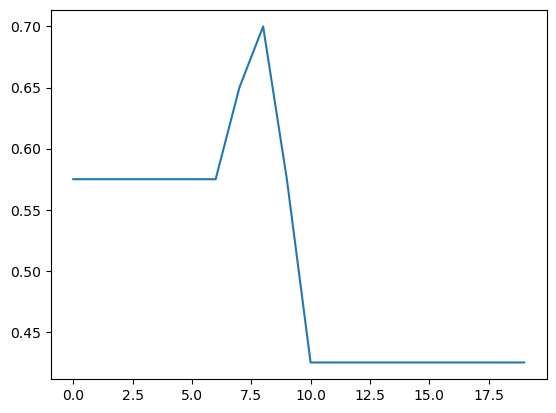

In [15]:
import matplotlib.pyplot as plt
plt.plot(accs)